In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

In [ ]:
from nbdev.showdoc import *

# Tutorial - Binary classification of chest X-rays

> In this tutorial we will build a classifier that distinguishes between chest X-rays with pneumothorax and chest X-rays without pneumothorax. The image data is loaded directly from the DICOM source files, so no prior DICOM data handling is needed.

## Download and import of X-ray DICOM files

First, we will use the `untar_data` function to download the _siim_small_ folder containing a subset (250 DICOM files, \~30MB) of the [SIIM-ACR Pneumothorax Segmentation](https://doi.org/10.1007/s10278-019-00299-9) \[1\] dataset.
The downloaded _siim_small_ folder will be stored in your _\~/.fastai/data/_ directory. The variable `pneumothorax-source` will store the absolute path to the _siim_small_ folder as soon as the download is complete.

In [ ]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

The _siim_small_ folder has the following directory/file structure:

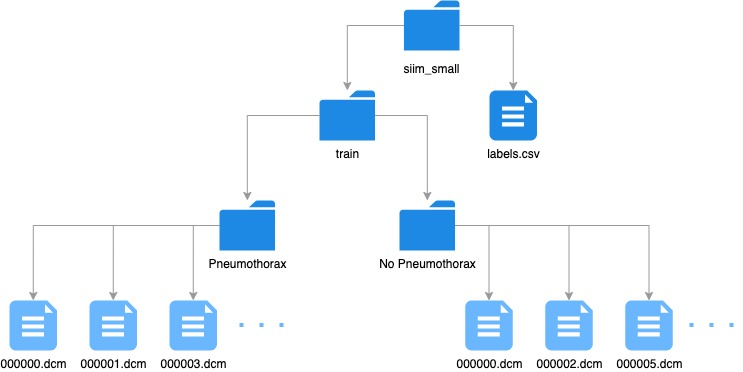

### Plotting the DICOM data

To analyze our dataset, we load the paths to the DICOM files with the `get_dicom_files` function. When calling the function, we append _train/_ to the `pneumothorax_source` path to choose the folder where the DICOM files are located. We store the path to each DICOM file in the `items` list.

In [ ]:
items = get_dicom_files(pneumothorax_source/f"train/")

Next, we split the `items` list into a train `trn` and validation `val` list using the `RandomSplitter` function:

In [ ]:
trn,val = RandomSplitter()(items)

To plot an X-ray, we can select an entry in the `items` list and load the DICOM file with `dcmread`. Then, we can plot it with the function `show`.

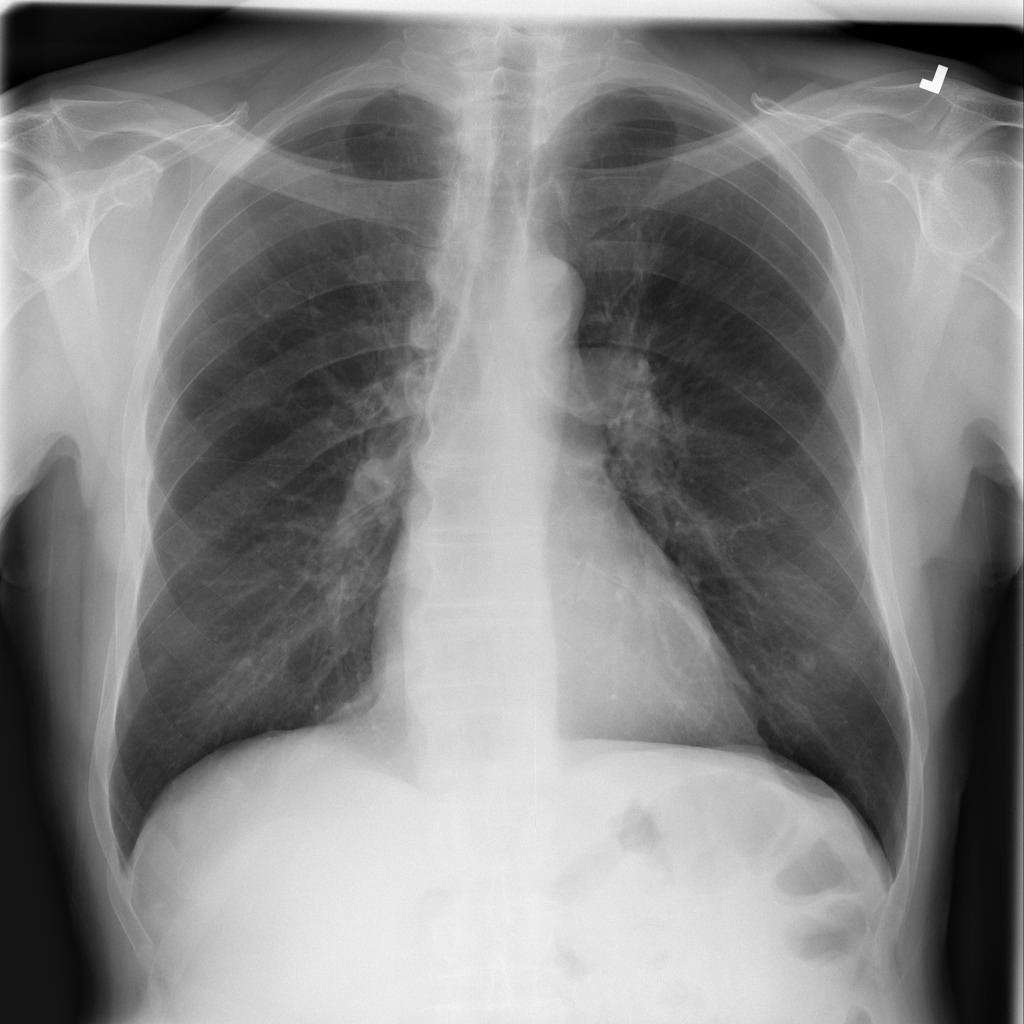

In [ ]:
patient = 3
xray_sample = dcmread(items[patient])
xray_sample

Next, we need to load the labels for the dataset. We import the _labels.csv_ file using pandas and print the first five entries. The **file** column shows the relative path to the _.dcm_ file and the **label** column indicates whether the chest x-ray has a pneumothorax or not.

In [ ]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


Now, we use the `DataBlock` class to prepare the DICOM data for training.

In [ ]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   batch_tfms=aug_transforms(size=224))

Additionally, we plot a first batch with the specified transformations:

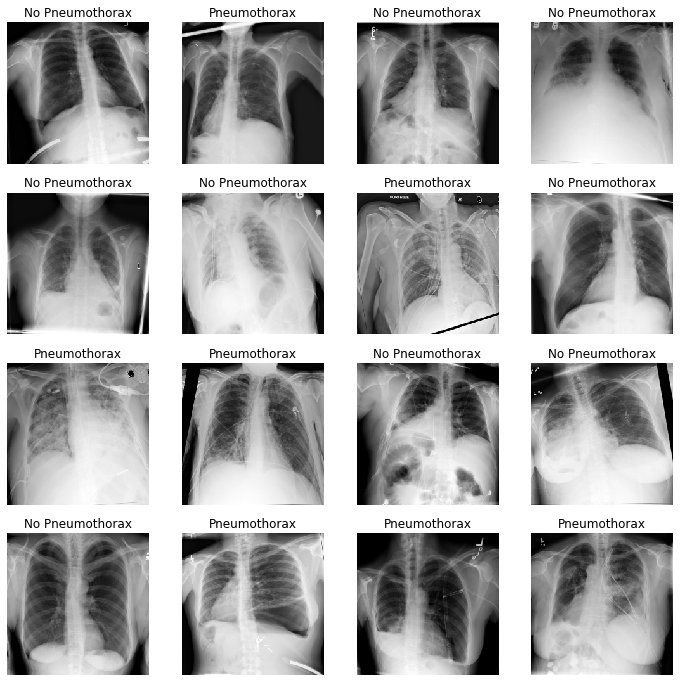

In [ ]:
dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=16)

## Training

We can then use the `cnn_learner` function and initiate the training.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.326462,1.284449,0.680000,00:02


In [ ]:
learn.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")

('No Pneumothorax', tensor(0), tensor([0.6970, 0.3030]))

In [ ]:
learn.tta(use_max=True)

(tensor([[0.0055, 0.9993],
         [0.9812, 0.8780],
         [0.9577, 0.1928],
         [0.7878, 0.4764],
         [0.9308, 0.8399],
         [0.9066, 0.9326],
         [0.8678, 0.9744],
         [0.5705, 0.9799],
         [0.9769, 0.9690],
         [0.9114, 0.5970],
         [0.9020, 0.8246],
         [0.4670, 0.8732],
         [0.2653, 0.9341],
         [0.9875, 0.7931],
         [0.1408, 0.9926],
         [0.5915, 0.9406],
         [0.6196, 0.9710],
         [0.7801, 0.9390],
         [0.9640, 0.9548],
         [0.7010, 0.9500],
         [0.8182, 0.9395],
         [0.5122, 0.9652],
         [0.7772, 0.9711],
         [0.8288, 0.9917],
         [0.7024, 0.7739],
         [0.8927, 0.7084],
         [0.9607, 0.2931],
         [0.8322, 0.9327],
         [0.9352, 0.6105],
         [0.8354, 0.7830],
         [0.9314, 0.6713],
         [0.8757, 0.9572],
         [0.7274, 0.8375],
         [0.6508, 0.9552],
         [0.6639, 0.9729],
         [0.8515, 0.6170],
         [0.5860, 0.7279],
 

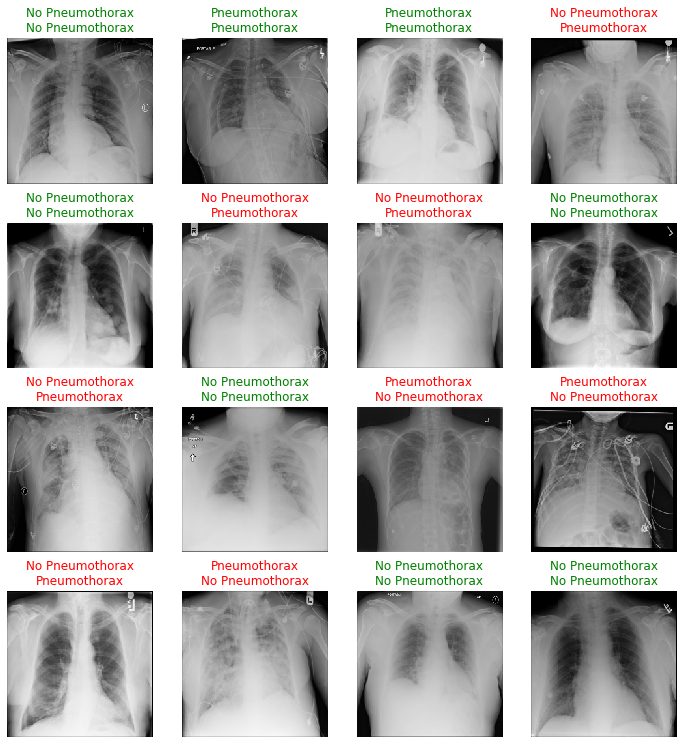

In [ ]:
learn.show_results(max_n=16)

In [ ]:
interp = Interpretation.from_learner(learn)

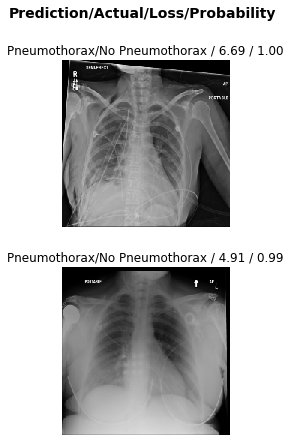

In [ ]:
interp.plot_top_losses(2)

_**Citations:**_

\[1\] _Filice R et al. Crowdsourcing pneumothorax annotations using machine learning annotations on the NIH chest X-ray dataset.  J Digit Imaging (2019). https://doi.org/10.1007/s10278-019-00299-9_